# Real-time flooding alerts

#### Imports

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.express as px
import plotly.io as pio
# Set notebook mode to work in offline
pio.renderers.default = 'iframe+pdf'

## Accès aux données

#### API observartions_tr

the "Hydrometry" API from the HYDRO Centrale (PHyC) platform, operated by the Service Central d'Hydrométéorologie et d'Appui à la Prévision des Inondations (SCHAPI).
- https://hubeau.eaufrance.fr/page/api-hydrometrie (see explanations at the end of the notebook)

(API used by Vigicrue)

I used the Seine as an example, with the hydrometric station located under the Austerlitz bridge.

In [2]:
url = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr"

params = {
    "code_entite": "F700000103", # station code    
    "grandeur_hydro": ['H','Q'], # hydrometric variables choosen
    "date_debut_obs": '2023-10-05', # observation start date
    "date_fin_obs": '2023-10-06', # observation end date
    #"latitude": 48.854209,
    #"longitude": 2.348725,
    #"distance": 5,
    #"size": 20,
    #"timestep": 20
}

response = requests.get(url, params=params)

print("status code:",response.status_code)

if response.status_code == '200' or '206': # status codes are detailed on the website
    data = response.json()
    df = pd.DataFrame(data["data"])    
else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 200


In [3]:
# Height results
df_H = df.loc[df['grandeur_hydro'] == 'H'].copy()
df_H['date_obs'] = pd.to_datetime(df_H['date_obs'])

# Flow rate results
df_Q = df.loc[df['grandeur_hydro'] == 'Q'].copy()
df_Q['date_obs'] = pd.to_datetime(df_Q['date_obs'])

#### Graphs

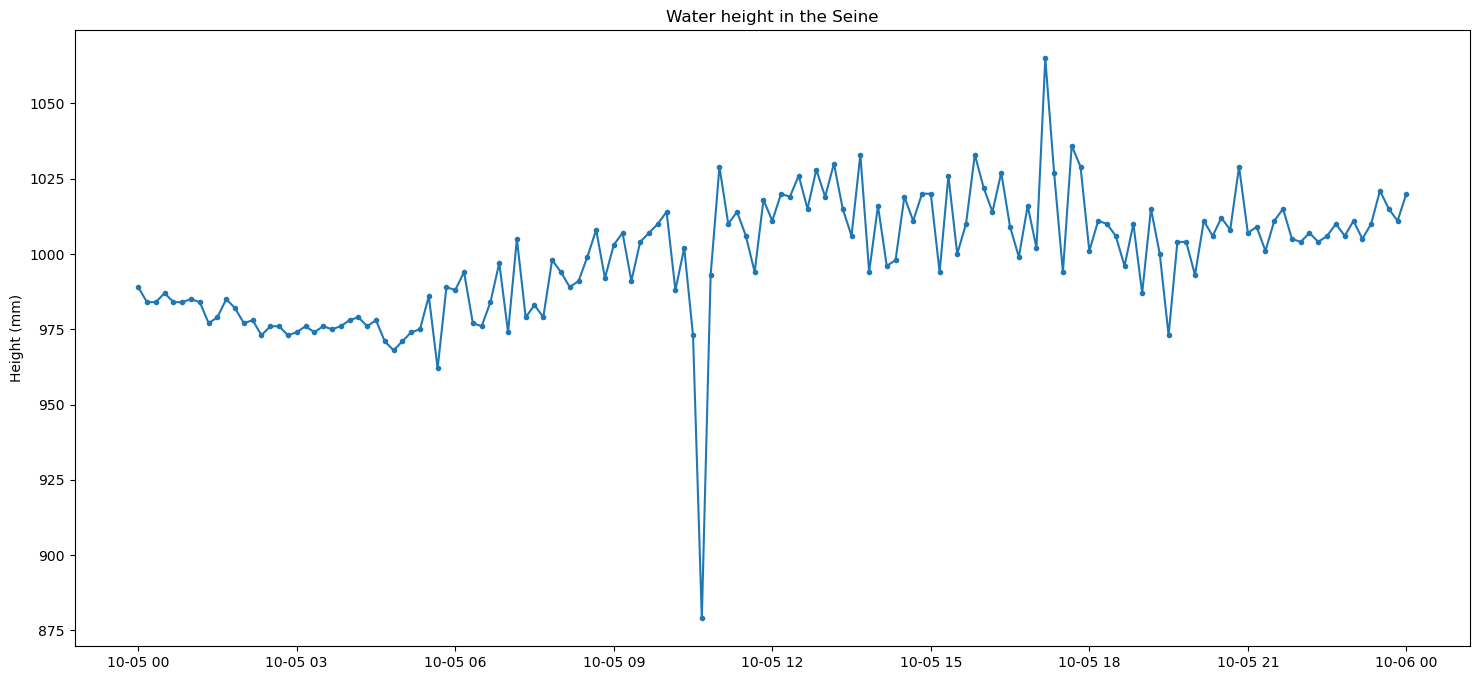

In [4]:
plt.figure(figsize=(18,8))
plt.plot(df_H['date_obs'],df_H['resultat_obs'],marker='.')
plt.title("Water height in the Seine" )
plt.ylabel("Height (mm)")

plt.show()

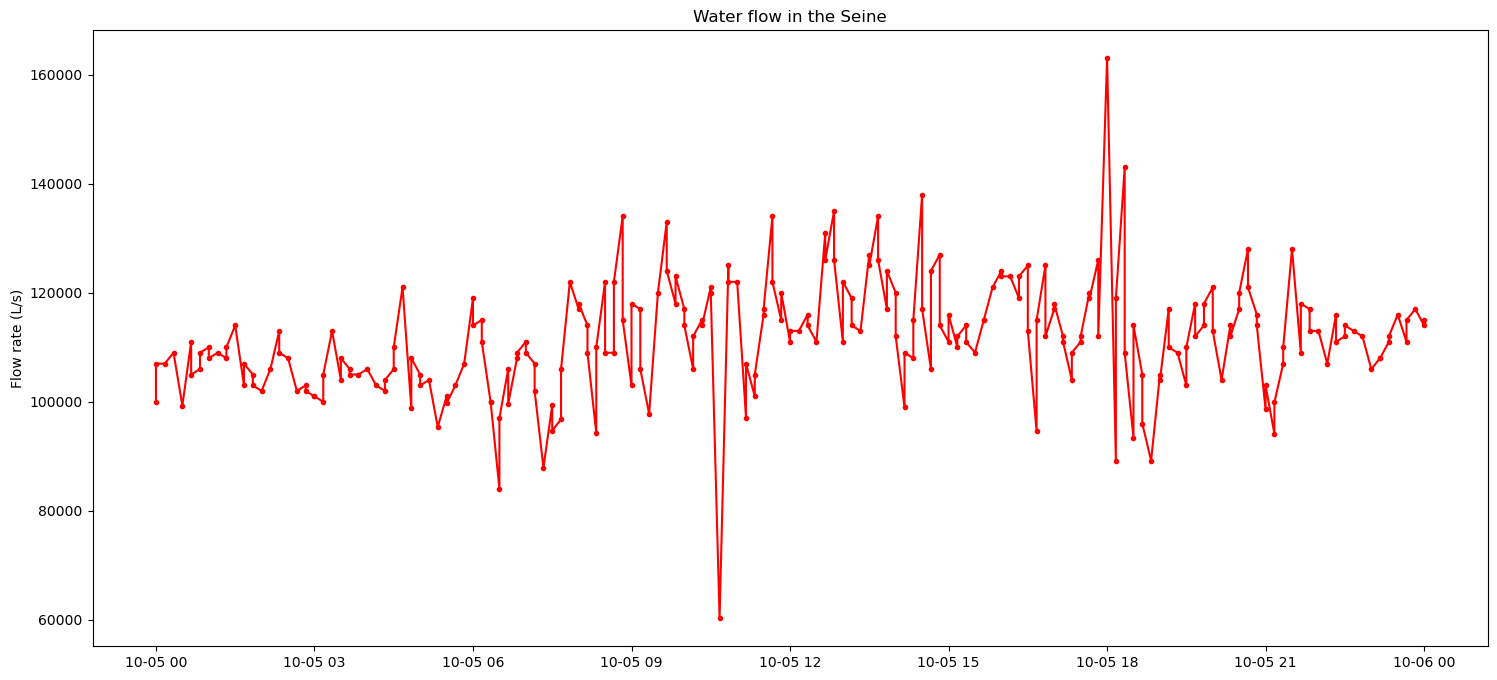

In [5]:
plt.figure(figsize=(18,8))
plt.plot(df_Q['date_obs'],df_Q['resultat_obs'],marker='.',color='r')
plt.title("Water flow in the Seine")
plt.ylabel("Flow rate (L/s)")

plt.show()

In [6]:
df.head()

,code_site,code_station,grandeur_hydro,date_debut_serie,date_fin_serie,statut_serie,code_systeme_alti_serie,date_obs,resultat_obs,code_methode_obs,libelle_methode_obs,code_qualification_obs,libelle_qualification_obs,continuite_obs_hydro,longitude,latitude
0,F7000001,F700000103,H,2023-10-05T23:50:00Z,2023-10-06T00:00:00Z,4,31,2023-10-06T00:00:00Z,1020.0,0,Mesure,16,Non qualifiée,True,2.365511,48.84469
1,F7000001,F700000103,Q,2023-10-02T03:10:00Z,2023-10-09T07:00:00Z,12,31,2023-10-06T00:00:00Z,115000.0,4,Reconstitution,20,Bonne,True,2.365511,48.84469
2,F7000001,F700000103,Q,2023-10-05T23:50:00Z,2023-10-06T00:00:00Z,4,31,2023-10-06T00:00:00Z,114000.0,0,Mesure,16,Non qualifiée,True,2.365511,48.84469
3,F7000001,F700000103,H,2023-10-05T23:50:00Z,2023-10-06T00:00:00Z,4,31,2023-10-05T23:50:00Z,1011.0,0,Mesure,16,Non qualifiée,True,2.365511,48.84469
4,F7000001,F700000103,Q,2023-10-05T23:50:00Z,2023-10-06T00:00:00Z,4,31,2023-10-05T23:50:00Z,117000.0,0,Mesure,16,Non qualifiée,True,2.365511,48.84469


#### Explication de chaque paramètre

(https://hubeau.eaufrance.fr/page/api-hydrometrie j'ai utilisé le 3eme endpoint)

bbox (Rectangle d'emprise de l'objet demandé):
- Il s'agit d'un filtre pour spécifier une zone géographique. Vous définissez un rectangle en utilisant les coordonnées WGS84 (EPSG:4326) sous la forme "min longitude, min latitude, max longitude, max latitude".
Exemple : bbox=1.6194,47.7965,2.1910,47.9988 pour une zone autour de Paris.

code_entite (Code de la station hydrométrique) :
- Vous pouvez spécifier des codes de stations hydrométriques pour filtrer les résultats. Vous pouvez également utiliser un pattern comme "K*" pour obtenir des stations dont le code commence par "K".
Exemple : code_entite=J4310010 pour une station spécifique ou code_entite=K* pour toutes les stations dont le code commence par "K".

cursor (Curseur de pagination) :
- Ce paramètre permet de paginer les résultats en utilisant un curseur. Il est généralement renseigné avec une valeur obtenue lors de la première requête pour récupérer les pages suivantes.
Exemple : cursor=eyJjb25zdW1lciI6IjIwMjMtMTItMjZUMT..." (valeur du curseur obtenue précédemment).

date_debut_obs (Date de début d'observation hydro) :
- Vous pouvez spécifier une date de début au format ISO 8601 pour filtrer les observations hydrométriques. La date ne peut pas être antérieure d'un mois par rapport à la date actuelle.
Exemple : date_debut_obs=2023-09-01 pour obtenir des observations à partir du 1er septembre 2023.

date_fin_obs (Date de fin d'observation hydro) :
- Il s'agit de la date de fin pour filtrer les observations hydrométriques.
Exemple : date_fin_obs=2023-09-30 pour obtenir des observations jusqu'au 30 septembre 2023.

distance (Rayon de recherche en kilomètre) :
- Si vous souhaitez rechercher des observations dans un rayon autour d'un point spécifique, vous pouvez utiliser ce paramètre en spécifiant la distance en kilomètres.
Exemple : distance=30 pour rechercher dans un rayon de 30 kilomètres autour du point spécifié.

fields (Liste des champs souhaités dans la réponse) :
- Vous pouvez spécifier les champs que vous souhaitez inclure dans la réponse. Par exemple, si vous voulez seulement les codes de station et les localisations, vous pouvez utiliser fields=code_station,localisation.

grandeur_hydro (Grandeur hydrométrique observée pour la série) :
- Vous pouvez spécifier les grandeurs hydrométriques que vous souhaitez obtenir. Les deux valeurs possibles sont "H" (hauteur d'eau) et "Q" (débit).
Exemple : grandeur_hydro=H pour obtenir seulement les observations de hauteur d'eau.

latitude et longitude (Latitude et longitude du point) :
- Si vous recherchez des observations dans un rayon autour d'un point spécifique, vous devez spécifier la latitude et la longitude de ce point en utilisant le format WGS84.
Exemple : latitude=48.8566 et longitude=2.3522 pour Paris.

size (Nombre maximum de résultats dans une page) :
- Vous pouvez spécifier le nombre maximal de résultats que vous souhaitez obtenir dans une seule page de résultats. Par défaut, la valeur est de 20.
Exemple : size=50 pour obtenir jusqu'à 50 résultats par page.

sort (Ordre de tri) :
- Vous pouvez spécifier l'ordre de tri des résultats en fonction de la date d'observation. Les valeurs possibles sont "asc" (ascendant) et "desc" (descendant).
Exemple : sort=asc pour trier les observations par date croissante.

timestep (Pas de temps fixe exprimé en minutes) :
- Ce paramètre permet de spécifier un pas de temps fixe en minutes pour les observations. Cependant, il ne fonctionne que lorsque vous effectuez une recherche sur un seul code_entite, et le service n'a pas de pagination.
Exemple : timestep=30 pour obtenir des observations toutes les 30 minutes.

##### Autres liens

- https://www.hydro.eaufrance.fr/stationhydro/F700000103/fiche

#### API stations

In [7]:
url_stations = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/referentiel/stations"

response_stations = requests.get(url_stations, params={"size": 6000})
if response_stations.status_code == '200' or '206': # status codes are detailed on the website
    data_stations = response_stations.json()
    df = pd.DataFrame(data_stations["data"])
else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

df.head()

,code_site,libelle_site,code_station,libelle_station,type_station,coordonnee_x_station,coordonnee_y_station,code_projection,longitude_station,latitude_station,...,code_finalite_station,type_contexte_loi_stat_station,type_loi_station,code_sandre_reseau_station,date_debut_ref_alti_station,date_activation_ref_alti_station,date_maj_ref_alti_station,libelle_departement,en_service,geometry
0,10110001,[Barbotteau] à Petit-Bourg,1011000101,[Barbotteau] à Petit-Bourg - Barbotteau,LIMNI,643352.000000,1.790354e+06,39,-61.658990,16.189402,...,1.0,NaN,NaN,"[BSH164, POH129, POH208]",2012-11-01T00:00:00Z,2017-07-11T00:00:00Z,2021-10-11T00:00:00Z,GUADELOUPE,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
1,10110002,[Grande riviere a goyave] à Petit-Bourg,1011000201,[Grande riviere a goyave] à Petit-Bourg - Peti...,LIMNI,644100.000000,1.791070e+06,39,-61.651950,16.195829,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
2,10110003,[La Grande Rivière à Goyaves à Petit-Bourg-Bar...,1011000301,[La Grande Rivière à Goyaves à Petit-Bourg-Bar...,LIMNI,643710.000000,1.790860e+06,39,-61.655610,16.193954,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
3,10110004,[La Grande Rivière à Goyaves à Petit-Bourg [Ve...,1011000401,[La Grande Rivière à Goyaves à Petit-Bourg [Ve...,LIMNI,641900.000000,1.786900e+06,39,-61.672778,16.158271,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
4,10150001,La rivière Bras David à Petit-Bourg [Maison Fo...,1015000101,La rivière Bras David à Petit-Bourg [Maison Fo...,LIMNI,639703.868935,1.788847e+06,39,-61.693200,16.175998,...,NaN,NaN,NaN,None,2001-07-01T00:00:00Z,2017-07-17T00:00:00Z,2022-03-15T00:00:00Z,GUADELOUPE,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."


In [8]:
# We check the names of the columns that contain at least 50% of null values
df.isnull().sum()

code_site                                  0
libelle_site                               0
code_station                               0
libelle_station                            0
type_station                               0
coordonnee_x_station                       0
coordonnee_y_station                       0
code_projection                            0
longitude_station                          0
latitude_station                           0
influence_locale_station                 726
commentaire_station                     3370
altitude_ref_alti_station               2748
code_systeme_alti_site                  2748
code_commune_station                       0
libelle_commune                           27
code_departement                          27
code_region                               27
libelle_region                            27
code_cours_eau                            39
libelle_cours_eau                        445
uri_cours_eau                             39
descriptif

In [9]:
# We remove the columns that contain at least 50% of null values
df = df.dropna(axis=1, thresh=int(0.5*len(df)))
df.head()

,code_site,libelle_site,code_station,libelle_station,type_station,coordonnee_x_station,coordonnee_y_station,code_projection,longitude_station,latitude_station,...,code_finalite_station,type_contexte_loi_stat_station,type_loi_station,code_sandre_reseau_station,date_debut_ref_alti_station,date_activation_ref_alti_station,date_maj_ref_alti_station,libelle_departement,en_service,geometry
0,10110001,[Barbotteau] à Petit-Bourg,1011000101,[Barbotteau] à Petit-Bourg - Barbotteau,LIMNI,643352.000000,1.790354e+06,39,-61.658990,16.189402,...,1.0,NaN,NaN,"[BSH164, POH129, POH208]",2012-11-01T00:00:00Z,2017-07-11T00:00:00Z,2021-10-11T00:00:00Z,GUADELOUPE,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
1,10110002,[Grande riviere a goyave] à Petit-Bourg,1011000201,[Grande riviere a goyave] à Petit-Bourg - Peti...,LIMNI,644100.000000,1.791070e+06,39,-61.651950,16.195829,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
2,10110003,[La Grande Rivière à Goyaves à Petit-Bourg-Bar...,1011000301,[La Grande Rivière à Goyaves à Petit-Bourg-Bar...,LIMNI,643710.000000,1.790860e+06,39,-61.655610,16.193954,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
3,10110004,[La Grande Rivière à Goyaves à Petit-Bourg [Ve...,1011000401,[La Grande Rivière à Goyaves à Petit-Bourg [Ve...,LIMNI,641900.000000,1.786900e+06,39,-61.672778,16.158271,...,0.0,NaN,NaN,None,None,None,None,GUADELOUPE,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
4,10150001,La rivière Bras David à Petit-Bourg [Maison Fo...,1015000101,La rivière Bras David à Petit-Bourg [Maison Fo...,LIMNI,639703.868935,1.788847e+06,39,-61.693200,16.175998,...,NaN,NaN,NaN,None,2001-07-01T00:00:00Z,2017-07-17T00:00:00Z,2022-03-15T00:00:00Z,GUADELOUPE,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."


In [10]:
# We get all the unique regions and their code_region
regions = df["libelle_region"].unique().tolist()
code_regions = df["code_region"].unique().tolist()
print(regions)
print(code_regions)


['GUADELOUPE', 'MARTINIQUE', 'MAYOTTE', 'LA REUNION', 'GUYANE', None, 'GRAND EST', 'HAUTS-DE-FRANCE', 'BOURGOGNE-FRANCHE-COMTE', 'ILE-DE-FRANCE', 'CENTRE-VAL DE LOIRE', 'NORMANDIE', 'BRETAGNE', 'PAYS DE LA LOIRE', 'AUVERGNE-RHONE-ALPES', 'OCCITANIE', 'NOUVELLE-AQUITAINE', "PROVENCE-ALPES-COTE D'AZUR", 'CORSE']
['01', '02', '06', '04', '03', None, '44', '32', '27', '11', '24', '28', '53', '52', '84', '76', '75', '93', '94']


In [11]:
# We remove every row that is not in metropolitan france
regions_in_metropolitan_france = ['GRAND EST', 'HAUTS-DE-FRANCE', 'BOURGOGNE-FRANCHE-COMTE', 'ILE-DE-FRANCE', 'CENTRE-VAL DE LOIRE', 'NORMANDIE', 'BRETAGNE', 'PAYS DE LA LOIRE', 'AUVERGNE-RHONE-ALPES', 'OCCITANIE', 'NOUVELLE-AQUITAINE', "PROVENCE-ALPES-COTE D'AZUR", 'CORSE']
df = df[df["libelle_region"].isin(regions_in_metropolitan_france)]
df.head()

,code_site,libelle_site,code_station,libelle_station,type_station,coordonnee_x_station,coordonnee_y_station,code_projection,longitude_station,latitude_station,...,code_finalite_station,type_contexte_loi_stat_station,type_loi_station,code_sandre_reseau_station,date_debut_ref_alti_station,date_activation_ref_alti_station,date_maj_ref_alti_station,libelle_departement,en_service,geometry
263,A0220200,L'Augraben à Hégenheim,A022020001,L'Augraben à Hégenheim,LIMNI,1040359.0,6727986.0,26,7.528982,47.564377,...,NaN,1.0,2.0,"[POH001, POH044, POH122, POH905, RIC062, RIC312]",2002-07-01T00:00:00Z,2013-11-18T00:00:00Z,2020-12-14T00:00:00Z,HAUT-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
264,A0220650,Le ruisseau le Liesbach à Blotzheim,A022065001,Le ruisseau le Liesbach à Blotzheim,LIMNI,1038650.0,6730460.0,26,7.508168,47.587489,...,12.0,1.0,2.0,None,None,None,None,HAUT-RHIN,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
265,A0230100,[Le Liesbach] à Saint-Louis [Langenhaeuser],A023010001,[Le Liesbach] à Saint-Louis [Langenhaeuser],LIMNI,1041333.0,6732404.0,26,7.545294,47.603575,...,12.0,1.0,2.0,None,None,None,None,HAUT-RHIN,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
266,A0230200,Le ruisseau l'Augraben à Saint-Louis [Michelfe...,A023020001,Le ruisseau l'Augraben à Saint-Louis [Michelfe...,LIMNI,1042215.0,6731721.0,26,7.556488,47.596980,...,12.0,1.0,2.0,None,None,None,None,HAUT-RHIN,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
267,A0230201,Le ruisseau l'Augraben à Bartenheim [La Chaussée],A023020101,Le ruisseau l'Augraben à Bartenheim [La Chaussée],LIMNI,1038775.0,6736213.0,26,7.514202,47.639124,...,12.0,1.0,2.0,None,None,None,None,HAUT-RHIN,False,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."


In [12]:
# Next, we remove every row where the corresponding station is not active
df = df[df["en_service"] == True]
df.head()

,code_site,libelle_site,code_station,libelle_station,type_station,coordonnee_x_station,coordonnee_y_station,code_projection,longitude_station,latitude_station,...,code_finalite_station,type_contexte_loi_stat_station,type_loi_station,code_sandre_reseau_station,date_debut_ref_alti_station,date_activation_ref_alti_station,date_maj_ref_alti_station,libelle_departement,en_service,geometry
263,A0220200,L'Augraben à Hégenheim,A022020001,L'Augraben à Hégenheim,LIMNI,1.040359e+06,6.727986e+06,26,7.528982,47.564377,...,NaN,1.0,2.0,"[POH001, POH044, POH122, POH905, RIC062, RIC312]",2002-07-01T00:00:00Z,2013-11-18T00:00:00Z,2020-12-14T00:00:00Z,HAUT-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
275,A0410300,Le ruisseau le Muhlbach de Schoenau à Schœnau ...,A041030001,Le ruisseau le Muhlbach de Schoenau à Schœnau ...,LIMNI,1.044986e+06,6.801429e+06,26,7.647875,48.221808,...,7.0,1.0,2.0,"[POH001, POH044, POH122, POH905]",2004-07-08T00:00:00Z,2023-06-09T00:00:00Z,2023-06-09T00:00:00Z,BAS-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
283,A0530742,Le ruisseau le Heulachgraben [cours d'eau phré...,A053074201,Le ruisseau le Heulachgraben [cours d'eau phré...,LIMNI,1.044969e+06,6.809701e+06,26,7.654202,48.296112,...,17.0,NaN,NaN,"[POH001, POH044, POH122, POH905]",2021-05-06T00:00:00Z,2023-06-09T00:00:00Z,2023-06-09T00:00:00Z,BAS-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
288,A0610050,Le Rhin à Strasbourg [Sémaphore nord],A061005051,Le Rhin à Strasbourg [Sémaphore nord] - Limnim...,LIMNI,1.053972e+06,6.843250e+06,26,7.802871,48.592540,...,2.0,NaN,NaN,"[POH001, POH044, POH122, POH905, RIC062, RIC312]",2010-01-01T00:00:00Z,2020-04-22T00:00:00Z,2020-12-14T00:00:00Z,BAS-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."
289,A1000030,L'Ill à Oltingue [Pont D 21b],A100003001,L'Ill à Oltingue [Pont D 21b],LIMNI,1.030618e+06,6.718946e+06,26,7.392949,47.488084,...,12.0,1.0,2.0,"[POH001, POH044, POH122, POH905, RIC062, RIC312]",2006-09-07T00:00:00Z,2013-11-18T00:00:00Z,2020-12-14T00:00:00Z,HAUT-RHIN,True,"{'type': 'Point', 'crs': {'type': 'name', 'pro..."


In [13]:
# We remove every row where the longitude is between -15 and 40
df = df[(df["longitude_station"] > -15) & (df["longitude_station"] < 40)]

In [14]:
'''
geometry = [Point(xy) for xy in zip(df["longitude_station"], df["latitude_station"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world["continent"] == "Europe"]
world = world[world["name"] == "France"]
#france = world.loc[world['name'] == 'France']
gdf.plot(ax=world.plot(figsize=(70, 15)), marker='o', color='red', markersize=5)'''

'\ngeometry = [Point(xy) for xy in zip(df["longitude_station"], df["latitude_station"])]\ngdf = gpd.GeoDataFrame(df, geometry=geometry)\n\nworld = gpd.read_file(gpd.datasets.get_path(\'naturalearth_lowres\'))\nworld = world[world["continent"] == "Europe"]\nworld = world[world["name"] == "France"]\n#france = world.loc[world[\'name\'] == \'France\']\ngdf.plot(ax=world.plot(figsize=(70, 15)), marker=\'o\', color=\'red\', markersize=5)'

In [15]:
# We can now create a map with all the working stations in metropolitan france
fig = px.scatter_geo(df,lat='latitude_station',lon='longitude_station')
fig.update_layout(title = 'Stations in metropolitan France', title_x=0.5, autosize=True, height=800, geo=dict(
        center=dict(
            lat=46.5,
            lon=2.7274
        ),
        scope='europe',
        projection_scale=6
    ))
fig.show()

### Pour des coordonnées géographiques quelconques:

On récupère les stations dans un rayon de 10km du point géographique donné

In [16]:
url = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr"

params = {
    #"code_entite": "F700000103", # station code    
    "grandeur_hydro": ['H','Q'], # hydrometric variables choosen
    "date_debut_obs": '2023-10-14', # observation start date
    "date_fin_obs": '2023-10-15', # observation end date
    
    "latitude": 47.037186,
    "longitude": -0.388035,
    "distance": 25,
    #"size": 20,
    #"timestep": 20
}

response = requests.get(url, params=params)

print("status code:",response.status_code)

if response.status_code == '200' or '206': # status codes are detailed on the website
    data = response.json()
    df2 = pd.DataFrame(data["data"])    
else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 206


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_site                  1000 non-null   object 
 1   code_station               603 non-null    object 
 2   grandeur_hydro             1000 non-null   object 
 3   date_debut_serie           1000 non-null   object 
 4   date_fin_serie             1000 non-null   object 
 5   statut_serie               1000 non-null   int64  
 6   code_systeme_alti_serie    1000 non-null   int64  
 7   date_obs                   1000 non-null   object 
 8   resultat_obs               1000 non-null   float64
 9   code_methode_obs           1000 non-null   int64  
 10  libelle_methode_obs        1000 non-null   object 
 11  code_qualification_obs     1000 non-null   int64  
 12  libelle_qualification_obs  1000 non-null   object 
 13  continuite_obs_hydro       1000 non-null   bool  

In [18]:
df2

,code_site,code_station,grandeur_hydro,date_debut_serie,date_fin_serie,statut_serie,code_systeme_alti_serie,date_obs,resultat_obs,code_methode_obs,libelle_methode_obs,code_qualification_obs,libelle_qualification_obs,continuite_obs_hydro,longitude,latitude
0,L8213010,L821301001,H,2023-09-18T10:42:04Z,2023-10-18T10:00:00Z,12,31,2023-10-15T00:00:00Z,375.0,4,Reconstitution,20,Bonne,True,-0.186961,46.923082
1,L8213010,L821301001,H,2023-09-18T10:38:04Z,2023-10-18T10:00:00Z,8,31,2023-10-15T00:00:00Z,375.0,4,Reconstitution,20,Bonne,True,-0.186961,46.923082
2,L8213010,L821301001,Q,2023-09-18T10:42:04Z,2023-10-18T10:00:00Z,12,31,2023-10-15T00:00:00Z,35.0,4,Reconstitution,20,Bonne,True,-0.186961,46.923082
3,L8213010,L821301001,Q,2023-09-18T10:38:04Z,2023-10-18T10:00:00Z,8,31,2023-10-15T00:00:00Z,35.0,4,Reconstitution,20,Bonne,True,-0.186961,46.923082
4,L8213010,None,Q,2023-09-18T10:42:04Z,2023-10-18T10:00:00Z,12,31,2023-10-15T00:00:00Z,35.0,4,Reconstitution,20,Bonne,True,-0.186861,46.922941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,L8343010,None,Q,2023-09-18T09:56:04Z,2023-10-18T08:00:00Z,12,31,2023-10-14T21:55:00Z,100.0,4,Reconstitution,12,Douteuse,True,-0.356577,46.997612
996,L8343010,None,Q,2023-10-14T00:00:01Z,2023-10-14T22:00:00Z,4,31,2023-10-14T21:55:00Z,100.0,12,Interpolation,12,Douteuse,True,-0.356577,46.997612
997,L8343010,None,Q,2023-09-18T09:54:04Z,2023-10-18T08:00:00Z,8,31,2023-10-14T21:55:00Z,100.0,4,Reconstitution,12,Douteuse,True,-0.356577,46.997612
998,L8402110,L840211001,H,2023-09-18T12:20:05Z,2023-10-18T11:00:00Z,12,31,2023-10-14T21:55:00Z,-379.0,4,Reconstitution,20,Bonne,True,-0.154411,47.135905


On récupère les données géographiques de ces stations pour les afficher sur la carte

In [19]:
df3 = pd.merge(df2, df, on=['code_station'], how='inner')
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 602
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   code_site_x                       603 non-null    object 
 1   code_station                      603 non-null    object 
 2   grandeur_hydro                    603 non-null    object 
 3   date_debut_serie                  603 non-null    object 
 4   date_fin_serie                    603 non-null    object 
 5   statut_serie                      603 non-null    int64  
 6   code_systeme_alti_serie           603 non-null    int64  
 7   date_obs                          603 non-null    object 
 8   resultat_obs                      603 non-null    float64
 9   code_methode_obs                  603 non-null    int64  
 10  libelle_methode_obs               603 non-null    object 
 11  code_qualification_obs            603 non-null    int64  
 12  libelle_

In [20]:
fig = px.scatter_geo(df3,lat='latitude_station',lon='longitude_station')
fig.update_layout(title = 'Stations near our point', title_x=0.5, autosize=True, height=800, geo=dict(
        center=dict(
            lat=48.9,
            lon=2.349
        ),
        scope='europe',
        projection_scale=14
    ))
fig.show()